<a href="https://colab.research.google.com/github/NTT123/ai-notebooks/blob/master/RN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relational Neural Network

A simple neural network module for relational reasoning

https://arxiv.org/abs/1706.01427
https://papers.nips.cc/paper/7082-a-simple-neural-network-module-for-relational-reasoning.pdf

>[Relational Neural Network](#scrollTo=COHBUzv3LakE)

>>[Sort-of-CLEVR dataset](#scrollTo=5z5GYCfYL1a4)

>>[Model](#scrollTo=WYMqN9ttpyaP)

>>[Dataloader](#scrollTo=cvXcnub4yZBu)

>>[Training](#scrollTo=dVGlOWPu2qsT)

>>[Demo](#scrollTo=KReoH3_uglVK)



##  Sort-of-CLEVR dataset

In [1]:
!apt install libcairo2-dev -y -q
!pip install pycairo -q
!wget -q "https://media.wired.com/photos/5aecf815efa7377a337590ee/master/w_582,c_limit/FINALGettyImages-950416996-.jpg" -O bg.jpg
!pip3 install tensorboardX

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libpixman-1-dev libxcb-shm0-dev
0 upgraded, 4 newly installed, 0 to remove and 8 not upgraded.
Need to get 930 kB of archives.
After this operation, 3,985 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libcairo-script-interpreter2 amd64 1.15.10-2 [53.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpixman-1-dev amd64 0.34.0-2 [244 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxcb-shm0-dev amd64 1.13-1 [6,676 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libcairo2-dev amd64 1.15.10-2 [626 kB]
Fetched 930 kB in 4s (232 kB/s)
Selecting previously unselected package libca

In [0]:
import random
import cairo
import math 
from PIL import Image
import numpy as np

class Object(object):
    def __init__(self, shape, color, pos):
        self._shape = shape
        self._color = color
        self._pos   = pos

        
colorlist = ['red', 'blue', 'green', 'orange', 'yellow', 'gray']

colors = {
'red'    : (255/255 ,   8/255,   0/255),
'blue'   : (31 /255 , 117/255, 254/255),
'green'  : (74 /255 , 255/255,   0/255),
'orange' : (237/255 , 135/255,  45/255),
'yellow' : (255/255 , 246/255,   0/255),
'gray'   : (103/255 , 103/255, 103/255),
}

class Env(object):
    def __init__(self, bg, num_obj=6, size=75, obj_size=5):
        self._num_obj = num_obj
        self._size    = size
        self._obj_size = obj_size
        bg = Image.open(bg)
        x = random.randint(0, bg.size[0]-1-size)
        y = random.randint(0, bg.size[1]-1-size)
        bg = bg.crop( box=(x, y, x+size, y+size) )
        bg.save("mybg__.png")
        self._bg = cairo.ImageSurface.create_from_png("mybg__.png")
        self._objs    = []
        for i in range(num_obj):
            color = colorlist[i]
            shape = random.choice(['square', 'circle'])
            done = False
            while not done:
                pos   = random.randint(obj_size, size-obj_size-1), random.randint(obj_size, size-obj_size-1)
                for o in self._objs:
                    dx = o._pos[0] - pos[0]
                    dy = o._pos[1] - pos[1]
                    
                    if dx**2 + dy**2 < 2 * (2*obj_size)**2:
                        break
                else:
                    done = True
                    self._objs.append(Object(shape=shape, color=color, pos=pos))
    def render(self, filename):
        with cairo.ImageSurface(cairo.FORMAT_ARGB32, self._size, self._size) as surface:
            context = cairo.Context(surface)
            #context.set_line_width(0.04)
            
            #context.set_source_rgb(0.9, 0.9, 0.9)
            #context.rectangle(0, 0, self._size, self._size)
            #context.fill()
            
            context.set_source_surface(self._bg, 0.0, 0.0)
            context.paint()
            
            for o in self._objs:
                if o._shape == "circle":
                    context.arc(o._pos[0], o._pos[1], self._obj_size, 0.0, 2.0*math.pi)
                    
                if o._shape == "square":
                    x1, y1 = o._pos[0] - self._obj_size, o._pos[1] - self._obj_size
                    context.rectangle(x1, y1,  2*self._obj_size , 2*self._obj_size)
                    
                context.set_source_rgb( *colors[o._color ] )
                context.fill_preserve()
                context.set_source_rgb(0.1, 0.1, 0.1)
                context.set_line_width(1)
                context.stroke()

            surface.write_to_png(filename)
            
    def generate_question(self):
        bits = [0 for _ in range(11)]
        bits[random.randint(0, 5)] = 1      # color
        bits[6 + random.randint(0, 1)] = 1  # question type
        bits[8 + random.randint(0, 2)] = 1  # question subtype
        
        return bits
    
    def answer_type_1_q1(self, o):
        # What is the shape of the red object?
        return o._shape
            
    def answer_type_1_q2(self, o):
        # Is the red object on the left or right of the image?
        if o._pos[0] < self._size//2:
            return "left"
        else:
            return "right"

    def answer_type_1_q3(self, o):
        # Is the red object on the top or bottom of the image?
        if o._pos[1] < self._size//2:
            return "top"
        else:
            return "bottom"

    def answer_type_2_q1(self, o):
        # What is the shape of the object that is closest to the green object?
        mindist = None
        minobj = None
        for oo in self._objs:
            if oo._color != o._color:
                dist = (o._pos[0] - oo._pos[0])**2 + (o._pos[1] - oo._pos[1])**2
                if mindist == None:
                    mindist = dist
                    minobj = oo
                elif mindist > dist:
                    mindist = dist
                    minobj = oo
        return minobj._shape
                   
            
    def answer_type_2_q2(self, o):
        # What is the shape of the object that is furthest from the green object?
        maxdist = None
        maxobj = None
        for oo in self._objs:
            if oo._color != o._color:
                dist = (o._pos[0] - oo._pos[0])**2 + (o._pos[1] - oo._pos[1])**2
                if maxdist == None:
                    maxdist = dist
                    maxobj = oo
                elif maxdist < dist:
                    maxdist = dist
                    maxobj = oo
        return maxobj._shape

    def answer_type_2_q3(self, o):
        # How many objects have the shape of the green object? 
        c = 0
        for oo in self._objs:
            if oo._shape == o._shape:
                c = c + 1
                
        return str(c)
    
    def parse_question(self, question):
        for i in range(6):
            if question[i] == 1:
                color = colorlist[i]
                
        typ= question[6]
        subtype = question[8] * 2 + question[9] * 1 + question[10] * 0 
        return color, typ, subtype
    
    def answer_question(self, question):
        c, t, st = self.parse_question(question)
        for o in self._objs:
            if o._color == c:
                break
        oracle =  [self.answer_type_1_q1, self.answer_type_1_q2, self.answer_type_1_q3]
        oracle += [self.answer_type_2_q1, self.answer_type_2_q2, self.answer_type_2_q3]
        
        return oracle[st + t*3](o)

    def question_to_english(self, question):
        lst = [ "What is the shape of the {} object?",
                "Is the {} object on the left or right of the image?",
                "Is the {} object on the top or bottom of the image?",
                "What is the shape of the object that is closest to the {} object?",
                "What is the shape of the object that is furthest from the {} object?",
                "How many objects have the shape of the {} object?" ]
        
        c, t, st = self.parse_question(question)
        print(t, st, c, st + 3*t)
        return lst[st + 3*t].format(c)
        

In [0]:
def generate_example(bg, out):
    myenv = Env(bg, size=128, obj_size=10)
    pair = []
    for _ in range(20):
        q = myenv.generate_question()
        ans = myenv.answer_question(q)
        q = "".join(map(str, q))
        pair.append("{} {} {}".format(out, q, ans.rjust(10)))
    
    myenv.render(out)
    return "\n".join(pair)    

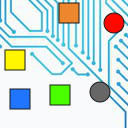

In [4]:
!mkdir env
examples = []
for i in range(10_000):
    examples.append(generate_example("bg.jpg", "env/{0:05d}.png".format(i)))
    
open('SortOfCLEVR.txt', "w").write("\n".join(examples))
from PIL import Image
Image.open("env/00000.png")

In [5]:
!head -n 4 SortOfCLEVR.txt

env/00000.png 01000001001     square
env/00000.png 00000101100     bottom
env/00000.png 00000101010      right
env/00000.png 01000010001     square


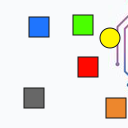

In [6]:
!mkdir env_test
examples = []
for i in range(1000):
    examples.append(generate_example("bg.jpg", "env_test/{0:05d}.png".format(i)))
    
open('SortOfCLEVR_test.txt', "w").write("\n".join(examples))
Image.open("env_test/00000.png")

In [7]:
!head -n 4 SortOfCLEVR_test.txt

env_test/00000.png 00010010001     square
env_test/00000.png 01000001100        top
env_test/00000.png 01000001001     square
env_test/00000.png 01000001010       left


## Model

In [8]:
!pip3 install torch torchvision -q

tcmalloc: large alloc 1073750016 bytes == 0x623f6000 @  0x7f90660f72a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(3, 24, 3, 2, 1, bias=False),
            nn.BatchNorm2d(24),            
            nn.ReLU(),
            nn.Conv2d(24, 24, 3, 2, 1, bias=False),
            nn.BatchNorm2d(24),            
            nn.ReLU(),
            nn.Conv2d(24, 24, 3, 2, 1, bias=False),
            nn.BatchNorm2d(24),            
            nn.ReLU(),
            nn.Conv2d(24, 24, 3, 2, 1, bias=False),
            nn.BatchNorm2d(24),            
            nn.ReLU(),
        )
        
    def forward(self, x):
        x = self.seq(x)
        
        return x
    
class RN(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Encoder()
        self.relations = nn.Sequential(
            nn.Conv2d(24*2+4 + 11, 128, 1, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 1, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 1, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 1, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.output = nn.Sequential(
            nn.Conv2d(128, 128, 1, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 1, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 1, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Dropout2d(0.5),

            nn.Conv2d(128, 12, 1, 1, 0, bias=False),
            nn.BatchNorm2d(12),
        )
        
        tag  = torch.linspace(-1, 1, 8)
        tagx = tag.unsqueeze(0).expand(8,8)
        tagy = tag.unsqueeze(1).expand(8,8)
        tag  = torch.stack((tagx, tagy), dim=0)
        
        self.register_buffer('tag', tag.unsqueeze(0)) 
        
    def forward(self, x, q):
        x = self.enc(x)
        
        tag = self.tag.expand(x.shape[0], self.tag.shape[1], self.tag.shape[2], self.tag.shape[3])
        
        x = torch.cat((x, tag), dim=1)
                
        x = x.reshape(x.shape[0], x.shape[1], -1)
        
        x1 = x.unsqueeze(2)
        x2 = x.unsqueeze(3)
        
        x1 = x1.expand(-1, -1, x1.shape[3], -1)
        x2 = x2.expand(-1, -1, -1, x2.shape[2])
        
        q = q.unsqueeze(2).unsqueeze(3)
        q = q.expand(-1, -1, x1.shape[2], x1.shape[3])
        
        x = torch.cat((x1, x2, q), dim=1)
        
        x = self.relations(x)
        x = x.reshape(x.shape[0], x.shape[1], -1).sum(dim=2)#.sum(dim=2)
        x = x.unsqueeze(2).unsqueeze(3)
        x = self.output(x)
        return x.squeeze()

## Dataloader

In [0]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import re

In [0]:
class SoCLEVR(Dataset):
    def __init__(self, filename, output_dic = {}):
        super().__init__()
        
        lines = open(filename, "r").readlines()
        self.output_dic = output_dic
        c = 0
        
        self.data = []
        self.env = {}
        
        for line in lines:
            line = line.strip()
            e, q, a = re.split("[ ]+", line)
            
            if e not in self.env:
                img = Image.open(e)
                self.env[e] = np.asarray(img)
            
            e = self.env[e]
            
            q = np.asarray(list(map(float, q)), dtype=np.float32)
            
            if a not in self.output_dic:
                self.output_dic[a] = c
                c = c + 1
            
            a = self.output_dic[a]
            
            self.data.append((e, q, a))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [0]:
soclevr = SoCLEVR("SortOfCLEVR.txt")

soclevr_test = SoCLEVR("SortOfCLEVR_test.txt", output_dic=soclevr.output_dic)

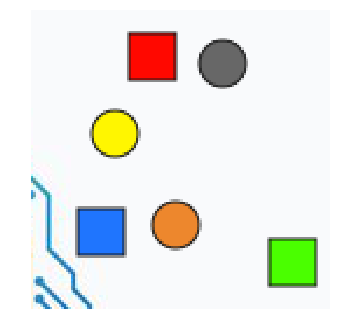

In [13]:
import matplotlib.pyplot as plt
plt.imshow(soclevr[1000][0])
_ = plt.axis("off")

## Training

In [0]:
dataloader = DataLoader(soclevr, batch_size=64, shuffle=True)

In [0]:
dataloader_test = DataLoader(soclevr_test, batch_size=64, shuffle=True)
dataloader_test_iter = iter(dataloader_test)

In [0]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
rn = RN().to(dev)

In [0]:
optimizer = torch.optim.Adam(rn.parameters(), lr=1e-4)
lossfn = nn.CrossEntropyLoss()

In [0]:
counter = 0

In [20]:
!pip install tensorboardcolab
from tensorboardcolab import *
tbc=TensorBoardColab(graph_path="./log")

Using TensorFlow backend.


Wait for 8 seconds...
TensorBoard link:
http://2cfd92cb.ngrok.io


In [0]:
from tensorboardX import SummaryWriter
writer = SummaryWriter(log_dir="./log/1_128_bn_relu")

In [22]:
for epoch in range(1, 10000):
    for step, (e, q, a) in enumerate(dataloader):
        counter = counter + 1
        e = e.permute(0, 3, 1, 2)
        e = e.float()/255*2 - 1.0 
        e = e.to(dev)
        q = q.to(dev)
        a = a.to(dev)

        output = rn(e, q)
        loss = lossfn(output, a)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        writer.add_scalar("loss", loss.item(), counter)
        
        if counter % 100 == 0:
            rn.eval()
            with torch.no_grad():
                e, q, a = dataloader_test_iter.next()
                e = e.permute(0, 3, 1, 2)
                e = e.float()/255*2 - 1.0 
                e = e.to(dev)
                q = q.to(dev)
                a = a.to(dev)
                output = rn(e, q)
                loss = lossfn(output, a)                
                acc = torch.sum(output.argmax(dim=1) == a) * 100.0 / output.shape[0]
                writer.add_scalar("test_accuracy", acc.item(), counter)
            rn.train()

KeyboardInterrupt: ignored

## Demo

In [0]:
#@title Download a trained model

#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


file_id = '12XyhvO2NjdzvZ4zuhFadC0y_MJn7UwbN'
download_file_from_google_drive(file_id, "model.ckpt")

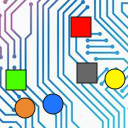

In [24]:
#@title Create a random environment
output_dic = {'1': 10,
 '2': 9,
 '3': 8,
 '4': 5,
 '5': 6,
 '6': 11,
 'bottom': 7,
 'circle': 1,
 'left': 4,
 'right': 2,
 'square': 3,
 'top': 0}

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rn = RN().to(dev)

rn.load_state_dict(torch.load("model.ckpt"))

rn = rn.eval()
from PIL import Image
_ = generate_example("bg.jpg", "env.png")
Image.open("env.png")

Each image has 6 objects. Each object has:
1.   shape: square or cicle
2.   color:  6 colors (red, blue, green, orange, yellow, gray) 
3.   position: any where  in a 128x128 env



In [0]:
#@title Ask a question { run: "auto" }
#@markdown Choose an object with color

object_color = "green"  #@param ['red', 'blue', 'green', 'orange', 'yellow', 'gray']

#@markdown Choose a question

question = "1 What is the shape of the object?" #@param ["1 What is the shape of the object?", "2 Is the object on the left or right of the image?", "3 Is the object on the top or bottom of the image?", "4 What is the shape of the object that is closest to the chosen object?", "5 What is the shape of the object that is furthest from the chosen object?", "6 How many objects have the shape of the chosen object?"]


for i in range(6):
    if object_color == colorlist[i]:
        break

q = [0 for _ in range(11)]
#print(i)
q[i] = 1

qq = int(question[0])
#print(qq)
if qq <= 3:
    q[7] = 1
    q[8 + (4-qq)-1] = 1
else:
    q[6] = 1 
    q[8 + (4-(qq-3))-1] = 1
    
q = list(map(int, q))

#print(q)
q = np.asarray(q, dtype=np.float32)
#print(i)

e = np.asarray(Image.open("env.png"), dtype=np.float32)
e = torch.from_numpy(e).permute(2, 0, 1).unsqueeze(0).to(dev)
e = e /255 * 2 - 1.0
q = torch.from_numpy(q).unsqueeze(0).to(dev)

out = rn(e, q)
#print(out)
o = torch.argmax(out).item()

idx2word = {}
for k, v in output_dic.items():
    idx2word[v] = k
    
print(idx2word[o])